In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
from collections import Counter
import re

In [23]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Загрузим файл на виртуальную среду 

In [89]:
idd = '1dAaDSuWAdQaSNEN5Xp67SBg0ALtKJowr'
downloaded_ = drive.CreateFile({'id':idd}) 
downloaded_.GetContentFile('train.csv')

import pandas as pd 
train = pd.read_csv('train.csv', sep=';')[:100000]

Так как задачей является классификация продуктов, поэтому информацией заложенной в названии категорий мы можем пренебречь. 
<br>Замапим категории, чтобы в дальнейшем номер категори можно было использовать как индекс единицы в one hot encoding (расчет Лосс функции), или в терминах вероятности, модель училась генерировать близкое к верному вероятностное распределние, например [1,0,0...0] (распределение для нулевой категори)

In [90]:
train.head(5)

,descr,category
0,ЯСНЫЕ ЗОРИ Филе ЦБ п/ф зам.подл.1кг,Замороженное мясо птицы
1,Вино ALESAN BORD.11.5%кр. 0.75л,Вино тихое
2,Карбонат ГУРМАН ЮБИЛЕЙНЫЙ 1кг,Деликатесы
3,Фисташки ЛЕДНИКОВЫЙ ПЕРИОД жар.сол.250г,Орехи
4,Грудинка ЮЖНАЯ в/к в/с 1кг,Деликатесы


In [91]:
transform = {i: str(indx) for indx, i in enumerate(train.category.unique())}
def transorm_(x):
  return transform[x]
train['labels'] = train['category'].apply(transorm_)
train.head()

,descr,category,labels
0,ЯСНЫЕ ЗОРИ Филе ЦБ п/ф зам.подл.1кг,Замороженное мясо птицы,0
1,Вино ALESAN BORD.11.5%кр. 0.75л,Вино тихое,1
2,Карбонат ГУРМАН ЮБИЛЕЙНЫЙ 1кг,Деликатесы,2
3,Фисташки ЛЕДНИКОВЫЙ ПЕРИОД жар.сол.250г,Орехи,3
4,Грудинка ЮЖНАЯ в/к в/с 1кг,Деликатесы,2


# EDA

Построим гистограмму распределения классов на тренировочной выборке.  

8584 Колбасные изделия


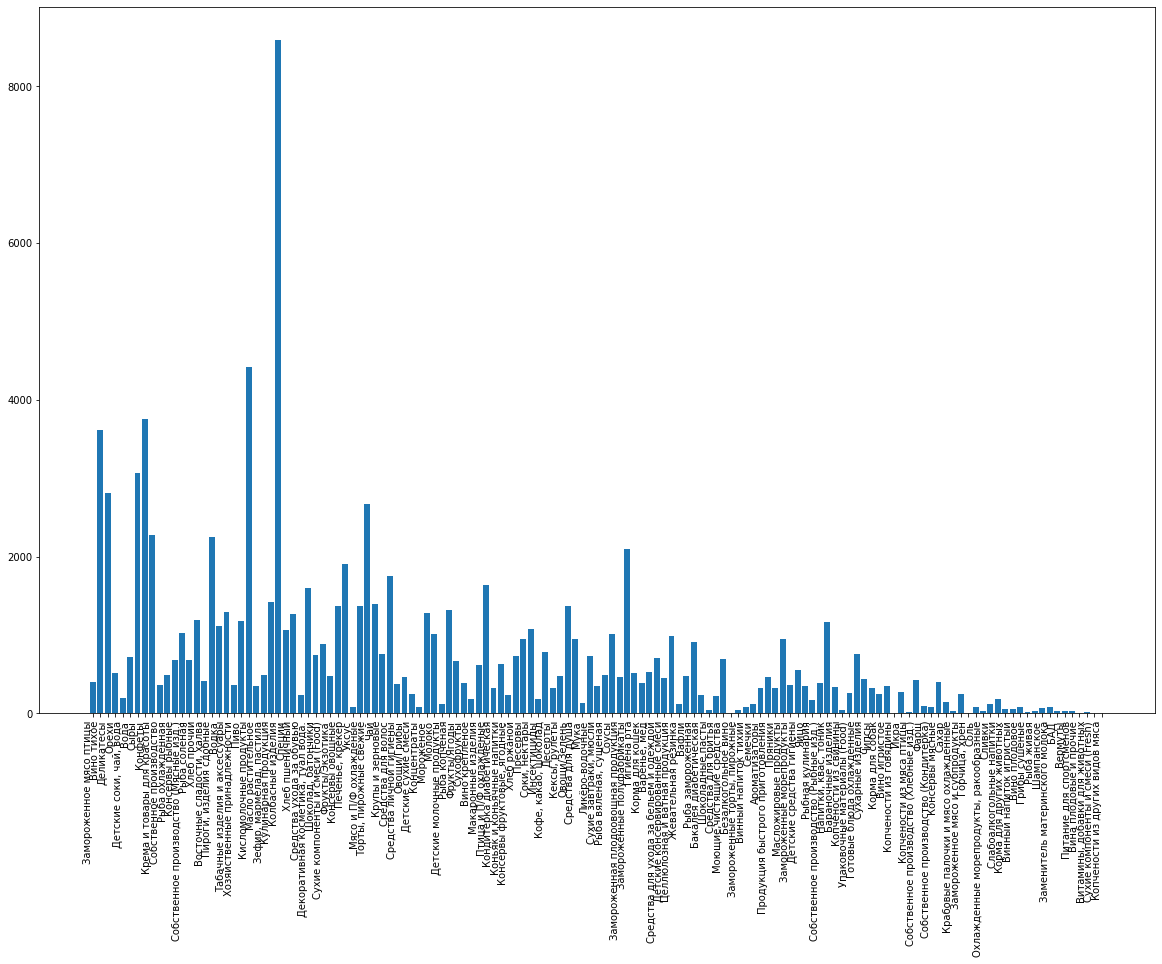

In [92]:
plt.figure(figsize=(20, 13))
to_bCh = Counter(train.category.tolist()).items()
h = [j for i,j in to_bCh]
lbls = [i for i,j in to_bCh]
plt.bar(range(len(transform)),h ,tick_label = lbls)
print(max(h), lbls[h.index(max(h))])
plt.xticks(rotation=90, ha='right')
plt.show()

In [93]:
train.head()

,descr,category,labels
0,ЯСНЫЕ ЗОРИ Филе ЦБ п/ф зам.подл.1кг,Замороженное мясо птицы,0
1,Вино ALESAN BORD.11.5%кр. 0.75л,Вино тихое,1
2,Карбонат ГУРМАН ЮБИЛЕЙНЫЙ 1кг,Деликатесы,2
3,Фисташки ЛЕДНИКОВЫЙ ПЕРИОД жар.сол.250г,Орехи,3
4,Грудинка ЮЖНАЯ в/к в/с 1кг,Деликатесы,2


In [94]:
to_bCh = sorted(to_bCh, key=lambda x: x[1], reverse = True)
print('Категории, содержащие наименьшим количество товаров в тренировочной выборке:')
for name, value in list((to_bCh))[:129:-1]:
  print( name, ':', value) 

Категории, содержащие наименьшим количество товаров в тренировочной выборке:
Сухие компоненты и смеси (Fresh) : 2
Вина плодовые и прочие : 3
Копчености из других видов мяса : 4
Копчености из говядины : 5
Безалкогольное вино : 6
Горчица, хрен : 9
Витамины, добавки для животных : 12


In [95]:
train.head()

,descr,category,labels
0,ЯСНЫЕ ЗОРИ Филе ЦБ п/ф зам.подл.1кг,Замороженное мясо птицы,0
1,Вино ALESAN BORD.11.5%кр. 0.75л,Вино тихое,1
2,Карбонат ГУРМАН ЮБИЛЕЙНЫЙ 1кг,Деликатесы,2
3,Фисташки ЛЕДНИКОВЫЙ ПЕРИОД жар.сол.250г,Орехи,3
4,Грудинка ЮЖНАЯ в/к в/с 1кг,Деликатесы,2


In [96]:
sum_values = 0
for name, value in list((to_bCh))[:129:-1]:
  sum_values+=value
print('Процентное соотношение товаров редких категории относительно тернировачной выборки - {0:0.2f}'.format(sum_values/train.shape[0]*100))

Процентное соотношение товаров редких категории относительно тернировачной выборки - 0.04


В целом, этими классами можно перенебречь, так как в них содержится менее 0.03% от общего количества товаров.  Кроме того, в дальнейшем, для оценки результатов будут использваться взвешенные метрики, что позволит невелировать ошибки(если таковые будут), касающиеся этих категорий.

In [97]:
train.head()

,descr,category,labels
0,ЯСНЫЕ ЗОРИ Филе ЦБ п/ф зам.подл.1кг,Замороженное мясо птицы,0
1,Вино ALESAN BORD.11.5%кр. 0.75л,Вино тихое,1
2,Карбонат ГУРМАН ЮБИЛЕЙНЫЙ 1кг,Деликатесы,2
3,Фисташки ЛЕДНИКОВЫЙ ПЕРИОД жар.сол.250г,Орехи,3
4,Грудинка ЮЖНАЯ в/к в/с 1кг,Деликатесы,2


Проведем предобработку названий

In [98]:
def clear(x):
  #x = ' '.join([i for i in re.findall('[^a-zA-Z]+', str(x).lower())])
  #x = re.sub('[\.%]',' ', x)
  x = re.sub('[0-9]+','', str(x).lower()) # Числовые значения хоть и косвенно несут информацию о категории продукта, однако они не стандартизированы и в при таких объемах могут создавать шум
  x = re.sub('[\.\-\+,"/%№]',' ', x) # заменим занки препинания и спец символы на пробелы
  x = re.sub('\s+',' ', x) # 
  
  return x

train['cl_descr'] = train.descr.apply(clear)
train.tail(40)

,descr,category,labels,cl_descr
99960,JOHN FRIEDA Крем-маска УКРЕПЛЯЮЩАЯ 150мл,Средства для волос,40,john frieda крем маска укрепляющая мл
99961,Филе трески NN б/к в/у 500г,Рыба замороженная,81,филе трески nn б к в у г
99962,Котлеты Воронеж.свино-говяж.Продсерв.1кг,Замороженные полуфабрикаты,72,котлеты воронеж свино говяж продсерв кг
99963,Мусс Валио творожный с черникой 4% 110г,Десерты,62,мусс валио творожный с черникой г
99964,"Конфеты""Джели""вес",Конфеты,7,конфеты джели вес
99965,MUTTI Соус SUGO POMOD.E BASILIC.том.280г,Соусы,70,mutti соус sugo pomod e basilic том г
99966,GATSBY Лосьон д/лица увл.муж.170мл,Крема и товары для красоты,8,gatsby лосьон д лица увл муж мл
99967,ЖЕЛЕЗНОГОР.Круассанчик с ананас.нач.70г,"Кексы, рулеты",63,железногор круассанчик с ананас нач г
99968,ДМИТРОГОРСКИЙ Колбаса ЧЕСНОЧНАЯ п/к 1кг,Колбасные изделия,25,дмитрогорский колбаса чесночная п к кг
99969,Сардина Унда в т/с с ключом ж/б 160г,Пресервы,58,сардина унда в т с с ключом ж б г


In [99]:
len(train.labels.unique())

137

Построим гистограмму распределения длин слов. Она позволит нам примерно оценить, сколько информации мы можем потерять если почистим названя продуктов от слов длины 2 и менее. 

[67433, 83843, 72393, 133311, 90353, 52176, 30334, 14828, 8605, 49547]


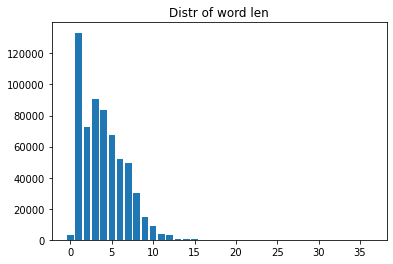

In [100]:
words = [word for text in train.cl_descr.tolist() for word in text.split(' ')]
m_f  = [w for w, fr in Counter(words).most_common(15)]
len_w_dist = [len(word) for word in words]
#print([len_word for len_word, fr in Counter(len_w_dist).items()])
a = [fr for len_word, fr in Counter(len_w_dist).items()]
print(a[:10])
plt.bar([len_word for len_word, fr in Counter(len_w_dist).items()], [fr for len_word, fr in Counter(len_w_dist).items()])
plt.title('Distr of word len')
plt.show()

Из гистограммы следует, что встречамость слов длиной 2 и менее в нашем датасете весьма велика, поэтому пренебрегать этой информацией не стоит. Скорее всего даже подходящие ко многим категория марекеры "кг", "мл" и т.д. могут иметь важное значение при классификации.

Нужна ли нормализация?

In [101]:
unique_words = set(words)
len(unique_words)

42913

In [102]:
!pip install pymorphy2

In [103]:
import pymorphy2
from tqdm import tqdm
morph = pymorphy2.MorphAnalyzer()
lemmas = []
for word in tqdm(set(words)):
  lemmas.append(morph.parse(word)[0].normal_form)

100%|██████████| 42913/42913 [00:08<00:00, 4848.59it/s]


In [104]:
unique_lemmas = set(lemmas)
len(unique_lemmas)

37260

Нормализация позволяет уменьшить вокабуляр на 10000 единиц. Однако, логично предположить, что существительные в названии продуктов, в большинстве своем, итак находятся в именительном падеже, прилагательные варьируются, а глаголы практически не используются. Проверим 

In [105]:
print('Процентное содержание лемм в исходном словаре : {0:.2f} %'.format(len(unique_words & unique_lemmas) / len(unique_words) * 100))

Процентное содержание лемм в исходном словаре : 68.11 %


In [106]:
list(unique_words & unique_lemmas)[:100]

['',
 'smokey',
 'гулибер',
 'nissan',
 'новокуйбыш',
 'харрис',
 'лэкотерия',
 'уничт',
 'взрывной',
 'meur',
 'вум',
 'сммл',
 'экстракт',
 'uniekaas',
 'негаз',
 'krone',
 'вацлавский',
 'ponola',
 'zubr',
 'шоколt',
 'primator',
 'антим',
 'matcha',
 'кутик',
 'ночь',
 'helena',
 'pol',
 'рембэр',
 'бутг',
 'катынь',
 'amat',
 'atria',
 'dari',
 'зубочистка',
 'people',
 'idea',
 'auten',
 'maple&nut',
 'ассортг',
 'метеорит',
 'берег',
 'kids',
 'ветчинашкольнаякур',
 'гигиенич',
 'ольц',
 'sabal',
 'рипас',
 'summer',
 'курицг',
 'шпиг',
 'минмл',
 'pompelmo',
 'празднич',
 'oolong',
 'гранд',
 'фетакса',
 'сул',
 'новогель',
 'блан',
 'морсель',
 'disin',
 'ready',
 'чп',
 'tiret',
 'ziolopex',
 'тминг',
 'марина',
 'кольский',
 'виногрг',
 'touc',
 'таман',
 'bahlsen',
 'neutrog',
 'tait',
 'гурман',
 'rapid',
 'royale',
 'выдкг',
 'киржач',
 'перецкг',
 'каштановый',
 'gustafsкг',
 'рубикон',
 'печеньице',
 'гранбираги',
 'padano',
 'европ',
 'гриссон',
 'ткань',
 'schlader',


Теперь стоит проверить качестсво слов, которых мы лишаемся при лемматизации. 

In [107]:
diff = list(set(words) - set(lemmas))[:50]
for indx, word in enumerate(diff):
  print("До : ",diff[indx], "\t\t\tПосле : ", morph.parse(word)[0].normal_form )

До :  слез 			После :  слеза
До :  лопаткастол 			После :  лопаткастола
До :  подтяг 			После :  подтяга
До :  пятачки 			После :  пятачок
До :  платиновая 			После :  платиновый
До :  колбасасалями 			После :  колбасасаль
До :  пехотная 			После :  пехотный
До :  микрофиброй 			После :  микрофибра
До :  сдоб 			После :  сдоба
До :  конферен 			После :  конферена
До :  мебели 			После :  мебель
До :  господаря 			После :  господарь
До :  мерло 			После :  мереть
До :  лимонная 			После :  лимонный
До :  хумус 			После :  хумуса
До :  швейцарского 			После :  швейцарский
До :  базарз 			После :  базарза
До :  жевательные 			После :  жевательный
До :  белладисеригнола 			После :  белладисеригнол
До :  творогом 			После :  творог
До :  цукатом 			После :  цукат
До :  альмет 			После :  альмета
До :  антипятин 			После :  антипятина
До :  шипучее 			После :  шипучий
До :  миндальной 			После :  миндальный
До :  желейная 			После :  желейный
До :  хорватские 			После :  хорватский
До :  сте

Можно заметить, что примерно в половине случаев, лемматизатор придумывает слова и не уменьшает пространство наших признаков. 

Таким образом, можно сделать вывод, что леммантизация имеет относительно невысокое значение в данной таске и возможно не приведет к улучшению точности, тем более, что пространствов признаков для каждого текста будет считаться с помощью тф-идф и искуственно расширяться по средствам включения биграмм.

## MLP

Согласно гипотезе Колмогорова, любую функцию можно апроксимировать трехслойным перцептроном с некоторыми параметрами, зависящиими от количества переменных. С него и начнем.

In [108]:
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics

Поделим данные на трейн и тест для того чтобы иметь возможность объективно оценить модели. При векторизации текстов используем тф-идф на уровне слова. Используем биграммы, чтобы отловить устойчивые сочетания в названии продуктов. Редкими словами будем пренебригать (меньше 5 вхождений), подключим стоп слова - наиболее частотные для этого датасета (12 - так как их частотности в несколько раз превышают последующие). 

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

# эту строчку не меняйте, будете делать тестирование(между эпохами) на этой небольшой выборке 
text_trian, text_test, labels_train, labels_test =  train_test_split(train.cl_descr, train.labels, test_size=0.05, random_state=42)

tf_transformer = TfidfVectorizer()

tf_transformer.fit(text_trian)
X_train_transformed = tf_transformer.transform(text_trian)
X_test_transformed = tf_transformer.transform(text_test)
labels_train = [int(x) for x in labels_train]
labels_test = [int(x) for x in labels_test]
X_train_transformed.shape # первая размерноть точно будет такой (350499, х)

(95000, 41246)

In [110]:
import numpy as np
from sklearn.metrics import classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

In [111]:
import torch
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

class WordData(Dataset):
    
    def __init__(self, x_data, y_data):
        
        super().__init__()
        
        self.x_data = x_data #пусть будет сохранен в память класса
        self.y_data = torch.LongTensor(y_data) #а это как тензор
        
    
    def __len__(self): # объязательный метод для этого класса, нужно уметь отдавать длину датасета 
        
        return self.x_data.shape[0] 
    
    def __getitem__(self, idx): # объязательный метод для этого класса, нужно уметь отдавать один семпл с данными и лейблом
        
        x = self.x_data[idx].toarray() # Будьте аккуратны, когда используете sparse matrix, так как изначально преобразовать их в массив нельзя - память кончится, будем препращать в массив отдельные строчки
        x = torch.FloatTensor(x) # преобразуем в тензор с флоат величинами
        y = self.y_data[idx]
        
        return x, y


dataset_train = WordData(X_train_transformed, labels_train)
dataset_test = WordData(X_test_transformed, labels_test)

batch_size = 32

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader =  DataLoader(dataset_test, batch_size=batch_size, shuffle=True)



In [112]:
from math import sqrt
class MLP(torch.nn.Module):
    
    def __init__(self, in_features, inner_features, inner_features2, out_features):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать 
        # в целом трех слоев будет достаточно

        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features) # out_features - количество категорий товаров, по которым вы хотите классифицировать, т.е. 138
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=inner_features2) # out_features - количество категорий товаров, по которым вы хотите классифицировать, т.е. 138
        self.linear_3 = torch.nn.Linear(in_features=inner_features2, out_features=out_features) # out_features - количество категорий товаров, по которым вы хотите классифицировать, т.е. 138
        self.non_linear_function = torch.nn.ReLU()
  
    def forward(self, x):
        
        # наша привычная схема
        
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.non_linear_function(x)
        x = self.linear_3(x) # это должен быть послдений слой в котором меняется размерность, никаких нелинейностей применть не нужно, софтмакс в Торче встроен в в кросс-энтропию для оптимизации
        
        return x
    

In [113]:
model = MLP(in_features=X_train_transformed.shape[1], inner_features=1524, inner_features2=1024, out_features=138)

In [114]:
model

MLP(
  (linear_1): Linear(in_features=41246, out_features=1524, bias=True)
  (linear_2): Linear(in_features=1524, out_features=1024, bias=True)
  (linear_3): Linear(in_features=1024, out_features=138, bias=True)
  (non_linear_function): ReLU()
)

In [115]:
for x, y in train_loader:
  print(model(x).shape)
  break #посмотрите внимательно на размерность

torch.Size([32, 1, 138])


In [116]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001,  betas=(0.9, 0.999) ) # это один из крутых оптимизаторв, можете для начала опробовать SGD
# aka loss function
criterion = torch.nn.CrossEntropyLoss() # будем считать потери с помощью привычной кросс энтропии

In [117]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device) # если мы работает на торче, можно оставить как есть; суть в том, что нашу модель можно перенести на видеокарту, 
                         # потом мы будем переводить туда и батчи с данными, это позволит нам обучаться быстрее, раз 5 как минимум

In [118]:
from sklearn.metrics import f1_score
epochs = 2

losses = []
predictions = []

for n_epoch in range(epochs):
  print('Epoch #{}\n'.format(n_epoch+1))

  train_losses = []
  train_predictions = []

  progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))


  for x, y in train_loader:

    optimizer.zero_grad()

    x = x.squeeze(1).to(device) # так как наша модель уже на ГПУ нужно и данные тоже туда пренести, кстати функция сквиз здесь это нормально, просто у нас есть лишняя развмерность и мы от нее избавляемся
    y = y.to(device)
    outputs = model(x)

    
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    losses.append(loss.item())

    _, predicted = torch.max(outputs.data, 1)
    train_predictions.append(predicted)
    predictions.append(predicted)

    
    progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))
    progress_bar.update(x.shape[0])

  progress_bar.close()
    # допиште обучалку, при этом следите за размерностями

  if type(predictions[0]) is not type(np.array([0])):
    predictions = [x.cpu().numpy() for x in predictions[:-1]]
  else:
    predictions = predictions[:-1]

  print('\n\nMean Loss after epoch #{0} - {1}'.format(str(n_epoch + 1), np.mean(losses)))

  test_predicteds = []
  test_labels = []
  test_loss = []

  with torch.no_grad():
    for x, y  in validation_loader:
      outputs = model(x.squeeze(1).to(device))
      _, predicted = torch.max(outputs.cpu().data, 1)
      loss = criterion(outputs.cpu(), y)
      test_loss.append(loss.item())
      test_labels.extend(y)
      test_predicteds.extend(predicted)
        

  f = f1_score(test_predicteds, test_labels, average = 'weighted')  
  print('\nLoss on test: {}'.format(np.mean(test_loss)))   
  print('F1 on test: {}\n\n'.format(f))
  

Epoch 1:   0%|          | 96/95000 [00:00<02:10, 728.37it/s, train_loss=4.93]

Epoch #1



Epoch 1: 100%|██████████| 95000/95000 [02:06<00:00, 751.29it/s, train_loss=0.438]




Mean Loss after epoch #1 - 0.9423846570444292


Epoch 2:   0%|          | 96/95000 [00:00<02:08, 737.82it/s, train_loss=0.436]


Loss on test: 0.4995741246469841
F1 on test: 0.872360747254678


Epoch #2



Epoch 2: 100%|██████████| 95000/95000 [02:05<00:00, 758.62it/s, train_loss=0.227]




Mean Loss after epoch #2 - 0.5741355525788155

Loss on test: 0.4853989980925041
F1 on test: 0.8813334184883869




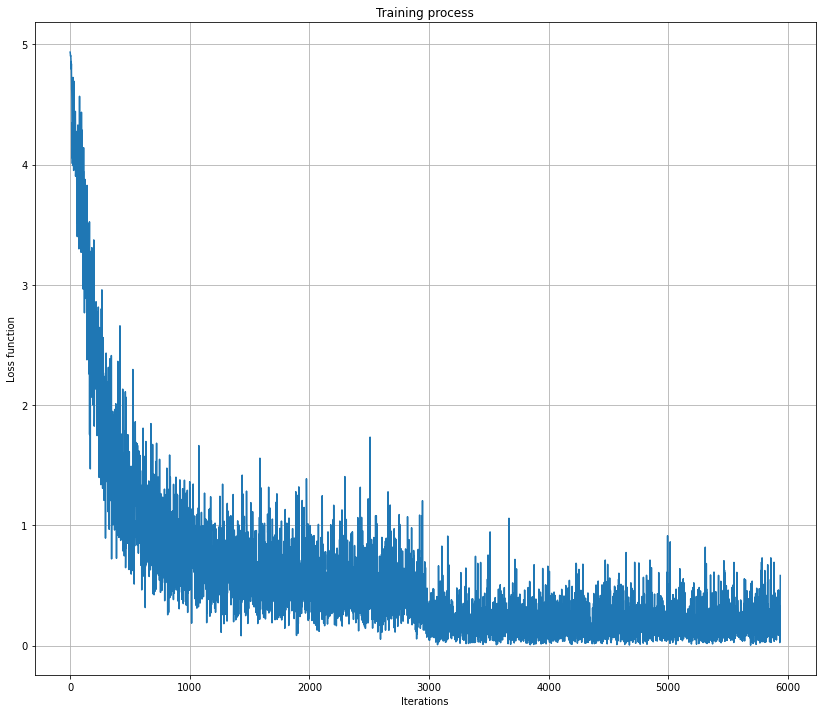

In [119]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');